# 1. Import Necessary Libraries
This block imports all the required libraries for data manipulation, preprocessing, model building, and evaluation.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import GRU, Dense, Masking, Dropout
from sklearn.utils.class_weight import compute_class_weight
from tabulate import tabulate

# 2. Load and Preprocess Data
This block reads the CSV file into a DataFrame, converts date columns to datetime, sorts the DataFrame, resets the index, and encodes categorical features to numerical values.


In [5]:
# Define File Path
file_path = "/Users/krista.rime/Documents/AIML/capstone_project.csv"

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)
df['EVENT_OCCURRED_UTC'] = pd.to_datetime(df['EVENT_OCCURRED_UTC'])
df.sort_values(by=['CLIENT_ID', 'SESSION_ID', 'EVENT_OCCURRED_UTC'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Convert event times to UNIX timestamps
df['EVENT_OCCURRED_UNIX'] = df['EVENT_OCCURRED_UTC'].apply(lambda x: x.timestamp())

# Encode APP_NAME
label_encoder = LabelEncoder()
df['APP_NAME_ENCODED'] = label_encoder.fit_transform(df['APP_NAME'])


# 3. Define Features and Handle Missing Values
Define features and handle missing values in the dataset.

In [7]:
# Define X
X = df.copy()

# Identify datetime and numerical features
datetime_features = df.select_dtypes(include=['datetime64']).columns
numerical_features = df.select_dtypes(include=['float64', 'int64']).columns

# Handle missing values in numerical features
numeric_df = df[df['EVENT_OCCURRED_UTC'].apply(lambda x: isinstance(x, (int, float)))]
if len(numeric_df) > 0:
    numerical_features = ['EVENT_OCCURRED_UTC']
    imputer = SimpleImputer(strategy='mean')
    numeric_df[numerical_features] = imputer.fit_transform(numeric_df[numerical_features])
else:
    df['EVENT_OCCURRED_UTC'] = pd.to_datetime(df['EVENT_OCCURRED_UTC']).apply(lambda x: x.timestamp())

df[datetime_features] = df[datetime_features].astype(np.int64)

# 4. Define Sequence Checking Function
This block defines a function to check if events within a session are in sequence, calculates time differences, and identifies heartbeat intervals.

In [9]:
def mark_and_identify_in_sequence(df):
    df.sort_values(by='EVENT_OCCURRED_UTC', inplace=True)
    df['TIME_DIFF'] = df['EVENT_OCCURRED_UTC'].diff().fillna(pd.Timedelta(seconds=0)).apply(lambda x: x.total_seconds())

    # Calculate heartbeat interval
    df['HEARTBEAT_INTERVAL'] = np.nan
    last_non_heartbeat_time = None

    for idx, row in df.iterrows():
        if row['EVENTNAME'] == 'heartBeat':
            if last_non_heartbeat_time is not None:
                df.at[idx, 'HEARTBEAT_INTERVAL'] = row['EVENT_OCCURRED_UNIX'] - last_non_heartbeat_time
            last_non_heartbeat_time = row['EVENT_OCCURRED_UNIX']
        else:
            last_non_heartbeat_time = row['EVENT_OCCURRED_UNIX']
    
    df['HEARTBEAT_INTERVAL_CLASS'] = df['HEARTBEAT_INTERVAL'].apply(
        lambda x: 'out_of_sequence' if (x < 19 or x > 21) else 'in_sequence' if pd.notnull(x) else np.nan
    )
    df['OUT_OF_SEQUENCE'] = df['HEARTBEAT_INTERVAL_CLASS'].apply(lambda x: x == 'out_of_sequence')
    return df

# Apply the function to group by CLIENT_ID and SESSION_ID
X_marked_with_out_of_sequence = X.groupby(['CLIENT_ID', 'SESSION_ID']).apply(mark_and_identify_in_sequence)
X_marked_with_out_of_sequence_reset = X_marked_with_out_of_sequence.reset_index(drop=True)

# 5. Verify Calculations
This block verifies the TIME_DIFF and HEARTBEAT_INTERVAL calculations.

In [10]:
print("Sample of TIME_DIFF and HEARTBEAT_INTERVAL calculations:")
print(X_marked_with_out_of_sequence_reset[['EVENT_OCCURRED_UTC', 'EVENTNAME', 'TIME_DIFF', 'HEARTBEAT_INTERVAL']].head(10))


Sample of TIME_DIFF and HEARTBEAT_INTERVAL calculations:
   EVENT_OCCURRED_UTC  EVENTNAME  TIME_DIFF  HEARTBEAT_INTERVAL
0 2024-04-02 04:03:39   cmPodEnd        0.0                 NaN
1 2024-04-02 14:29:52  heartBeat        0.0                 NaN
2 2024-04-02 14:30:27    clipEnd       35.0                 NaN
3 2024-04-02 07:27:44  heartBeat        0.0                 NaN
4 2024-04-02 07:28:04  heartBeat       20.0                20.0
5 2024-04-02 07:28:24  heartBeat       20.0                20.0
6 2024-04-02 07:28:44  heartBeat       20.0                20.0
7 2024-04-02 07:28:54    clipEnd       10.0                 NaN
8 2024-04-02 02:31:56   cmPodEnd        0.0                 NaN
9 2024-04-02 03:57:41  clipStart        0.0                 NaN


# 6. Prepare Data for the GRU Model
This block prepares the sequences for the GRU model, splits the data into training and testing sets, and pads sequences to a fixed length.

In [12]:
# Prepare the sequences for the GRU model
grouped = X_marked_with_out_of_sequence_reset.groupby(['CLIENT_ID', 'SESSION_ID'])
features = ['EVENT_OCCURRED_UNIX', 'TIME_DIFF', 'HEARTBEAT_INTERVAL', 'APP_NAME_ENCODED']
X_sequences = [group[features].fillna(0).values.tolist() for _, group in grouped]
y_labels = [int(any(group['OUT_OF_SEQUENCE'])) for _, group in grouped]

# Convert all elements in X_sequences to float
X_sequences = [[[float(item) for item in sublist] for sublist in seq] for seq in X_sequences]

# Pad sequences to a fixed length
max_sequence_length = max(len(seq) for seq in X_sequences)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length, padding='post', truncating='post', value=0, dtype='float32')

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

# 7. Build and Compile the GRU Model
This block builds and compiles the GRU model

In [14]:
input_shape = (max_sequence_length, X_train.shape[2])
model = Sequential()
model.add(Masking(mask_value=0., input_shape=input_shape))
model.add(GRU(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(GRU(units=100))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/Users/krista.rime/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# 8. Train the Model
This block trains the GRU model using the training data.


In [15]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
model.fit(X_train, np.array(y_train), epochs=20, batch_size=32, validation_split=0.2, class_weight=class_weights)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6667 - loss: 0.6680 - val_accuracy: 0.2500 - val_loss: 0.7178
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.5333 - loss: 0.5960 - val_accuracy: 0.2500 - val_loss: 0.8819
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.3333 - loss: 0.6110 - val_accuracy: 0.2500 - val_loss: 0.9117
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.3333 - loss: 0.6026 - val_accuracy: 0.2500 - val_loss: 0.8718
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step - accuracy: 0.4000 - loss: 0.5831 - val_accuracy: 0.5000 - val_loss: 0.7822
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.5333 - loss: 0.5694 - val_accuracy: 0.5000 - val_loss: 0.7296
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6667 - loss: 0.5038 - val_accuracy: 0.7500 - val_loss: 0.6036
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.7333 - loss: 0.4231 - val_accuracy: 0.7500 - val_loss: 0.

# 9. Evaluate the Model
This block evaluates the model using the testing data and prints the test loss and accuracy.

In [17]:
test_loss, test_accuracy = model.evaluate(X_test, np.array(y_test))
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 1.0000 - loss: 0.0906
Test Loss: 0.09058035165071487
Test Accuracy: 1.0


# 10. Report Out-of-Sequence Heartbeat Events
This block reports the out-of-sequence heartbeat events and displays the results in a tabular format.

In [18]:
out_of_sequence_events = X_marked_with_out_of_sequence_reset[
    (X_marked_with_out_of_sequence_reset['OUT_OF_SEQUENCE'] == True) & 
    (X_marked_with_out_of_sequence_reset['EVENTNAME'] == 'heartBeat')
]
out_of_sequence_table = out_of_sequence_events[
    ['EVENT_OCCURRED_UTC', 'APP_NAME', 'APP_VERSION', 'CLIENT_ID', 'SESSION_ID', 'EVENTNAME', 'HIT_ID',
     'EVENT_OCCURRED_UNIX', 'TIME_DIFF', 'OUT_OF_SEQUENCE', 'HEARTBEAT_INTERVAL', 'HEARTBEAT_INTERVAL_CLASS']
].values.tolist()
headers = ['EVENT_OCCURRED_UTC', 'APP_NAME', 'APP_VERSION', 'CLIENT_ID', 'SESSION_ID', 'EVENTNAME', 'HIT_ID',
           'EVENT_OCCURRED_UNIX', 'TIME_DIFF', 'OUT_OF_SEQUENCE', 'HEARTBEAT_INTERVAL', 'HEARTBEAT_INTERVAL_CLASS']

print("Out of Sequence Heartbeat Events:")
print(tabulate(out_of_sequence_table, headers=headers, tablefmt='grid'))

Out of Sequence Heartbeat Events:
+----------------------+------------+-------------------------------------------------+--------------------------------------+--------------------------------------+-------------+----------+-----------------------+-------------+-------------------+----------------------+----------------------------+
| EVENT_OCCURRED_UTC   | APP_NAME   | APP_VERSION                                     | CLIENT_ID                            | SESSION_ID                           | EVENTNAME   |   HIT_ID |   EVENT_OCCURRED_UNIX |   TIME_DIFF | OUT_OF_SEQUENCE   |   HEARTBEAT_INTERVAL | HEARTBEAT_INTERVAL_CLASS   |
+======================+============+=================================================+======================================+======================================+=============+==========+=======================+=============+===================+======================+============================+
| 2024-04-02 03:58:48  | roku       | 5.32.3-f150a6d10         

# 11. Summarize Out-of-Sequence Events
This block summarizes the out-of-sequence events by various categories and prints the results.

In [23]:
def summarize_out_of_sequence(df):
    total_events = len(df)
    total_out_of_sequence = df['OUT_OF_SEQUENCE'].sum()
    percentage_out_of_sequence = (total_out_of_sequence / total_events) * 100
    out_of_sequence_by_app = df.groupby('APP_NAME')['OUT_OF_SEQUENCE'].sum()
    out_of_sequence_by_app_version = df.groupby(['APP_NAME', 'APP_VERSION'])['OUT_OF_SEQUENCE'].sum()
    out_of_sequence_by_session_count = df.groupby('SESSION_ID')['OUT_OF_SEQUENCE'].sum()
    out_of_sequence_by_client_count = df.groupby('CLIENT_ID')['OUT_OF_SEQUENCE'].sum()
    total_sessions_with_out_of_sequence = (out_of_sequence_by_session_count > 0).sum()
    total_clients_with_out_of_sequence = (out_of_sequence_by_client_count > 0).sum()
    total_session_ids = len(out_of_sequence_by_session_count)
    total_client_ids = len(out_of_sequence_by_client_count)
    percentage_sessions_with_out_of_sequence = (total_sessions_with_out_of_sequence / total_session_ids) * 100
    percentage_clients_with_out_of_sequence = (total_clients_with_out_of_sequence / total_client_ids) * 100

    return total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, out_of_sequence_by_app_version, out_of_sequence_by_session_count, out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, percentage_clients_with_out_of_sequence

# Call the summarize function and unpack the results
total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, out_of_sequence_by_app_version, out_of_sequence_by_session_count, out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, percentage_clients_with_out_of_sequence = summarize_out_of_sequence(X_marked_with_out_of_sequence_reset)

# Print the summaries
print("Total Count of Events Out of Sequence:", total_out_of_sequence)
print("Percentage of Events Out of Sequence:", percentage_out_of_sequence, "%")
print("\nTotal Count of Events Out of Sequence by App:")
print(out_of_sequence_by_app)
print("\nTotal Count of Events Out of Sequence by App Version:")
print(out_of_sequence_by_app_version)
print("\nTotal Count of Session IDs with Out-of-Sequence Events:", total_sessions_with_out_of_sequence)
print("Percentage of Session IDs with Out-of-Sequence Events:", percentage_sessions_with_out_of_sequence, "%")
print("\nTotal Count of Client IDs with Out-of-Sequence Events:", total_clients_with_out_of_sequence)
print("Percentage of Client IDs with Out-of-Sequence Events:", percentage_clients_with_out_of_sequence, "%")

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, np.array(y_test))
print("\nTest Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

Total Count of Events Out of Sequence: 86
Percentage of Events Out of Sequence: 6.422703510082151 %

Total Count of Events Out of Sequence by App:
APP_NAME
roku    86
Name: OUT_OF_SEQUENCE, dtype: int64

Total Count of Events Out of Sequence by App Version:
APP_NAME  APP_VERSION                                    
roku      5.32.2-                                             0
          5.32.3-f150a6d10                                    9
          5.33.5-d1bde25c896954a4820cb95376a0eed925b5a4d9    77
Name: OUT_OF_SEQUENCE, dtype: int64

Total Count of Session IDs with Out-of-Sequence Events: 7
Percentage of Session IDs with Out-of-Sequence Events: 29.166666666666668 %

Total Count of Client IDs with Out-of-Sequence Events: 7
Percentage of Client IDs with Out-of-Sequence Events: 30.434782608695656 %
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 1.0000 - loss: 0.0906

Test Loss: 0.09058035165071487
Test Accuracy: 1.0


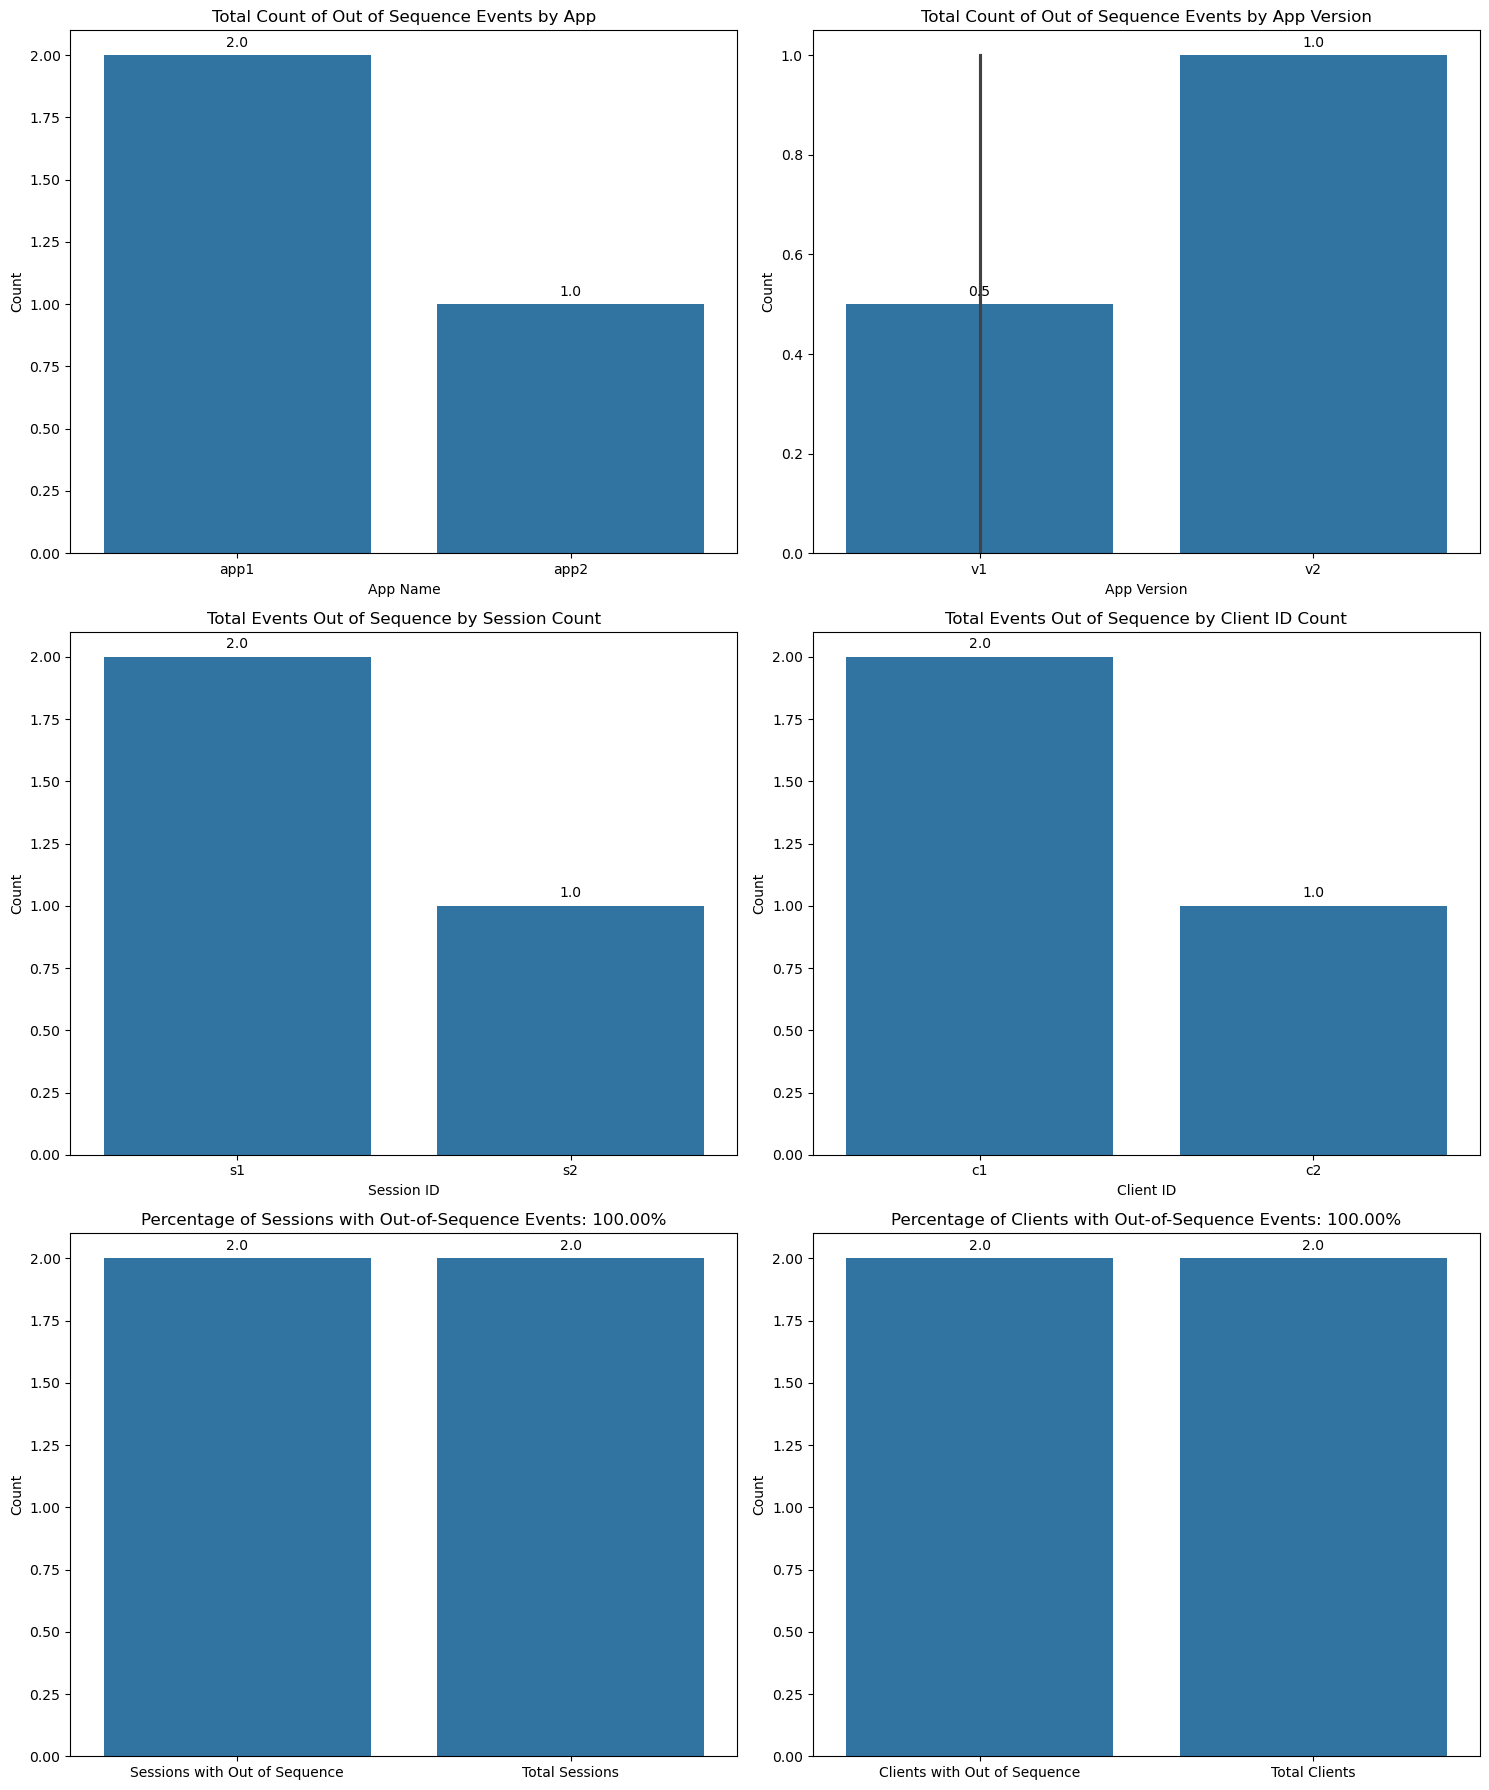

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample DataFrame, replace with actual DataFrame
data = {
    'APP_NAME': ['app1', 'app2', 'app1', 'app2'],
    'APP_VERSION': ['v1', 'v1', 'v2', 'v2'],
    'CLIENT_ID': ['c1', 'c2', 'c1', 'c2'],
    'SESSION_ID': ['s1', 's2', 's1', 's2'],
    'OUT_OF_SEQUENCE': [1, 0, 1, 1]
}
df = pd.DataFrame(data)

# Summarize the out of sequence events
def summarize_out_of_sequence(df):
    total_events = len(df)
    total_out_of_sequence = df['OUT_OF_SEQUENCE'].sum()
    percentage_out_of_sequence = (total_out_of_sequence / total_events) * 100
    out_of_sequence_by_app = df.groupby('APP_NAME')['OUT_OF_SEQUENCE'].sum()
    out_of_sequence_by_app_version = df.groupby(['APP_NAME', 'APP_VERSION'])['OUT_OF_SEQUENCE'].sum()
    out_of_sequence_by_session_count = df.groupby('SESSION_ID')['OUT_OF_SEQUENCE'].sum()
    out_of_sequence_by_client_count = df.groupby('CLIENT_ID')['OUT_OF_SEQUENCE'].sum()
    total_sessions_with_out_of_sequence = (out_of_sequence_by_session_count > 0).sum()
    total_clients_with_out_of_sequence = (out_of_sequence_by_client_count > 0).sum()
    total_session_ids = len(out_of_sequence_by_session_count)
    total_client_ids = len(out_of_sequence_by_client_count)
    percentage_sessions_with_out_of_sequence = (total_sessions_with_out_of_sequence / total_session_ids) * 100
    percentage_clients_with_out_of_sequence = (total_clients_with_out_of_sequence / total_client_ids) * 100
    
    return (total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, 
            out_of_sequence_by_app_version, out_of_sequence_by_session_count, 
            out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, 
            total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, 
            percentage_clients_with_out_of_sequence, total_session_ids, total_client_ids)

# Call the summarize function
results = summarize_out_of_sequence(df)
(total_out_of_sequence, percentage_out_of_sequence, out_of_sequence_by_app, 
 out_of_sequence_by_app_version, out_of_sequence_by_session_count, 
 out_of_sequence_by_client_count, total_sessions_with_out_of_sequence, 
 total_clients_with_out_of_sequence, percentage_sessions_with_out_of_sequence, 
 percentage_clients_with_out_of_sequence, total_session_ids, total_client_ids) = results

# Define a function to add value labels on bars
def add_value_labels(ax):
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.1f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

# Create a figure with subplots
fig, axs = plt.subplots(3, 2, figsize=(15, 18))

# Total count of events out of sequence by app
sns.barplot(x=out_of_sequence_by_app.index, y=out_of_sequence_by_app.values, ax=axs[0, 0])
axs[0, 0].set_title('Total Count of Out of Sequence Events by App')
axs[0, 0].set_xlabel('App Name')
axs[0, 0].set_ylabel('Count')
add_value_labels(axs[0, 0])

# Total count of events out of sequence by app version
sns.barplot(x=out_of_sequence_by_app_version.index.get_level_values(1), y=out_of_sequence_by_app_version.values, ax=axs[0, 1])
axs[0, 1].set_title('Total Count of Out of Sequence Events by App Version')
axs[0, 1].set_xlabel('App Version')
axs[0, 1].set_ylabel('Count')
add_value_labels(axs[0, 1])

# Total events out of sequence by session count
sns.barplot(x=out_of_sequence_by_session_count.index, y=out_of_sequence_by_session_count.values, ax=axs[1, 0])
axs[1, 0].set_title('Total Events Out of Sequence by Session Count')
axs[1, 0].set_xlabel('Session ID')
axs[1, 0].set_ylabel('Count')
add_value_labels(axs[1, 0])

# Total events out of sequence by client ID count
sns.barplot(x=out_of_sequence_by_client_count.index, y=out_of_sequence_by_client_count.values, ax=axs[1, 1])
axs[1, 1].set_title('Total Events Out of Sequence by Client ID Count')
axs[1, 1].set_xlabel('Client ID')
axs[1, 1].set_ylabel('Count')
add_value_labels(axs[1, 1])

# Percentage of sessions with out-of-sequence events
sns.barplot(x=['Sessions with Out of Sequence', 'Total Sessions'], y=[total_sessions_with_out_of_sequence, total_session_ids], ax=axs[2, 0])
percentage_sessions = (total_sessions_with_out_of_sequence / total_session_ids) * 100
axs[2, 0].set_title(f'Percentage of Sessions with Out-of-Sequence Events: {percentage_sessions:.2f}%')
axs[2, 0].set_ylabel('Count')
add_value_labels(axs[2, 0])

# Percentage of clients with out-of-sequence events
sns.barplot(x=['Clients with Out of Sequence', 'Total Clients'], y=[total_clients_with_out_of_sequence, total_client_ids], ax=axs[2, 1])
percentage_clients = (total_clients_with_out_of_sequence / total_client_ids) * 100
axs[2, 1].set_title(f'Percentage of Clients with Out-of-Sequence Events: {percentage_clients:.2f}%')
axs[2, 1].set_ylabel('Count')
add_value_labels(axs[2, 1])

plt.tight_layout()
plt.show()
